<a href="https://colab.research.google.com/github/richeung1/Handwritten-Data/blob/main/TrOCR_Trial_with_Small_Handwritten_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TRAINING**

In [ ]:
!pip install -q transformers

In [ ]:
import pandas as pd

In [ ]:
df_train=pd.read_csv('/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/written_name_train_10k.csv')

In [ ]:
df_train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
df_train['IDENTITY'] = df_train['IDENTITY'].astype(str)

In [ ]:
import torch

In [ ]:
from PIL import Image

In [ ]:
train_path = '/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/train_jpg_10k'

In [ ]:
image = Image.open(train_path + '/'+ df_train['FILENAME'][0]).convert("RGB")

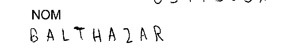

In [ ]:
image

In [ ]:
from torch.utils.data import Dataset

In [ ]:
import os
from torchvision.io import read_image

In [ ]:
annotations_file = '/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/written_name_train_10k.csv'
img_dir = '/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/train_jpg_10k'

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['FILENAME'][idx]
        text = self.df['IDENTITY'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/written_name_validation_3k.csv')
df_val['IDENTITY'] = df_val['IDENTITY'].astype(str)

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = CustomImageDataset(root_dir='/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/train_jpg_10k/',
                           df=df_train,
                           processor=processor)
eval_dataset = CustomImageDataset(root_dir='/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/validation_jpg_3k/',
                           df=df_val,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 10000
Number of validation examples: 3000


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


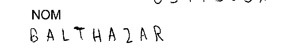

In [ ]:
image = Image.open(train_dataset.root_dir + df_train['FILENAME'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

BALTHAZAR


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_metric

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import evaluate
from evaluate import load

In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# cer_metric = evaluate.load("cer")

In [ ]:
cer_metric = load_metric("cer")

In [ ]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
from transformers import AdamW

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(1):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
    
   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer 

   print("Validation CER:", valid_cer / len(eval_dataloader))


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2500 [00:00<?, ?it/s]

Loss after epoch 0: 1.685537536740303


  0%|          | 0/750 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Validation CER: 0.36734258854513224


In [ ]:
model.save_pretrained('/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/mymodel')

# **INFERENCING**





In [ ]:
from PIL import Image

In [ ]:
test_path = '/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/test_jpg_1k'

In [ ]:
import pandas as pd

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/written_name_test_1k.csv')

In [ ]:
df_test['FILENAME'] = df_test['FILENAME'].astype(str)

In [ ]:
image = Image.open(test_path + '/'+ df_test['FILENAME'][0]).convert("RGB")

In [ ]:
image

In [ ]:
!pip install -q transformers

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# calling the processor is equivalent to calling the feature extractor
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


torch.Size([1, 3, 384, 384])


In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/mymodel")

In [ ]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


KEVOUIN


In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/mymodel")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
test_path = '/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/test_jpg_1k/'

In [ ]:
image = Image.open(test_path + '/'+ df_test['FILENAME'][0]).convert("RGB")

In [ ]:
image

In [ ]:
def process_image(image):
    # prepare image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # generate (no beam search)
    generated_ids = model.generate(pixel_values)

    # decode
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

In [ ]:
title = "Interactive demo: TrOCR"
description = "Demo for Microsoft's TrOCR, an encoder-decoder model consisting of an image Transformer encoder and a text Transformer decoder for state-of-the-art optical character recognition (OCR) on single-text line images. This particular model is fine-tuned on IAM, a dataset of annotated handwritten images. To use it, simply upload an image or use the example image below and click 'submit'. Results will show up in a few seconds."
article = "TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models | Github Repo"
examples =[["/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/test_jpg_1k/TEST_0001.jpg"], ["/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/test_jpg_1k/TEST_0002.jpg"], ["/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/test_jpg_1k/TEST_0003.jpg"]]

In [ ]:
iface = gr.Interface(fn=process_image, 
                     inputs=gr.inputs.Image(type="pil"), 
                     outputs=gr.outputs.Textbox(),
                     title=title,
                     description=description,
                     article=article,
                     examples=examples,
                     flagging_options=['Correct', 'Incorrect', 'Ambiguous'],
                     flagging_dir='/content/drive/MyDrive/Machine Learning Colab Notebooks/TrOCR/Flagged')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


In [ ]:
iface.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://4cda429b-5441-4355.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
